In [1]:



using Images
using PyPlot


# Create a gaussian filter
function makegaussianfilter(size::Array{Int,2},sigma::Float64)
    
  x_either_len=div(size[1,2],2)  # finds either side length, eg. 2 for 5

  f1= zeros(1,size[1,2]) # x vector
  f2= zeros(size[1,1],1)# y vector

  for i=1:size[1,2]   # creates x vector
        f1[1,i]=(1/((sqrt(2*pi))*sigma))*e^(-(x_either_len)^2/(2*(sigma^2)))   
        x_either_len=x_either_len-1   # modifying it like 2 1 0 -1 -2
      
   end 

   f1_sum=sum(f1)
   f1=f1./f1_sum   # now f1 has sum of 1  as it has been normalised
    
  # repeat for y direction
   y_either_len=div(size[1,1],2)

  for i=1:size[1,1]
        f2[i,1]=(1/((sqrt(2*pi))*sigma))*e^(-(y_either_len)^2/(2*(sigma^2)))   
        y_either_len=y_either_len-1   # modifying it like 2 1 0 -1 -2
        
  end

  f2_sum=sum(f2)
  f2=f2./f2_sum    # this also makes the sum as 1

  f=f2*f1   # convolution operator
          
  return f::Array{Float64,2}
end




makegaussianfilter (generic function with 1 method)

In [2]:
# Create a binomial filter
function makebinomialfilter(size::Array{Int,2})
    # size = [3 3]
 
  x_len=size[1,2]-1 # for length 3 we have upto 2 index

  f1= zeros(1,size[1,2])
  f2= zeros(size[1,1],1)

  for i=1:size[1,2]
      f1[1,i]=factorial(x_len) /((factorial(x_len-i+1))*factorial(i-1))   # for N elements we have to go till n-1
  end

  

  f1_sum=sum(f1)
  f1=f1./f1_sum   # now f1 has sum of 1

  y_len=size[1,1]-1

  for i=1:size[1,1]
      f2[i,1]=factorial(y_len) /((factorial(y_len-i+1))*factorial(i-1))   
  end


  f2_sum=sum(f2)        
  f2=f2./f2_sum    # this also makes the sum as 1

  f=f2*f1   # convolution operator
   
  return f::Array{Float64,2}
end





makebinomialfilter (generic function with 1 method)

In [3]:
# Downsample an image by a factor of 2
function downsample2(A::Array{Float64,2})
    
  D=zeros((div(size(A,1),2),div(size(A,2),2)))
        
  im_h=size(A,1)
  im_w=size(A,2)
  sI_h=size(D,1)
  sI_w=size(D,2)


 for i=1:2:im_h
    for j=1:2:im_w
        D[div((i+1),2),div((j+1),2)]=A[i,j]
    end
 end

  return D::Array{Float64,2}
end

# Upsample an image by a factor of 2
function upsample2(A::Array{Float64,2},fsize::Array{Int,2})
    
    
  U=zeros((size(A,1)*2),(size(A,2)*2))

  im_h=size(A,1)
  im_w=size(A,2)
  sI_h=size(U,1)
  sI_w=size(U,2)


  for i=1:sI_h
    for j=1:sI_w
        if(i%2==0 || j%2==0)
        U[i,j]=0
        else
        U[i,j]=A[div((i+1),2),div((j+1),2)]   
        end
    end
 end

Bf=makebinomialfilter(fsize)   # creates a binomial filter of 5*5   
sImage_BFiltered=imfilter(U,Bf,[border="symmetric"])

sImage_BFiltered=sImage_BFiltered.*4  # upscale each elemt by a factor of 4

U=sImage_BFiltered

  return U::Array{Float64,2}
end


upsample2 (generic function with 1 method)

In [4]:

# Build a gaussian pyramid from an image. 
# The output array should contain the pyramid levels in decreasing sizes.
function makegaussianpyramid(im::Array{Float32,2},nlevels::Int,fsize::Array{Int,2},sigma::Float64)
    
  G=Array{Array{Float64,2}}(nlevels) # 6 2D arrays

  G[1,1]=im
  gF=makegaussianfilter(fsize,sigma)
  for i=1:nlevels-1
      sImage_GFiltered=imfilter(im,gF,[border="symmetric"])
      K=downsample2(sImage_GFiltered)
      G[i+1,1]=K
      im=K
  end

 return G::Array{Array{Float64,2},1}
end

# Display a given image pyramid (laplacian or gaussian)
function displaypyramid(P::Array{Array{Float64,2},1})
    
  disp_height=size(P[1],1)  # the height of the gaussian/laplacian pyramid is the same as the height of the L0
  disp_width=0   # width grows so we need to calculate
  for i=1:size(P,1)  # loop for the pyramid depth
      disp_width=disp_width+size(P[i],2)   # we will have the width aftre the for loop completion
  end
    
  disp=zeros(disp_height,disp_width)   # initilising the gaussian/laplacian pyramid to display with all zeros so that the ones we can't fill will remain 0
    
  max=zeros(6)
  min=zeros(6)
  for i=1:size(P,1)
      max[i]=maximum(P[i])
      min[i]=minimum(P[i])
  end
    
  for i=1:size(P,1)   # need to normalise all the data area and dont touch the black areas
      P[i]=P[i].-min[i]
      P[i]=P[i]./((max[i]-min[i]))
  end 
    
  l=1  # want to keep the width index moving even if we change the level so introducing a variable
  l_offset=1
  for i=1:size(P,1)
  temp=P[i]
  for k=1:size(P[i],1)
      l=l_offset  #initialises l with the starting width of new level
      for j=1:size(P[i],2)
                   
          disp[k,l]=temp[k,j]
          l=l+1
        
      end
          
  end
    l_offset=l  # saves the value of l when we finish displaying one level so the this l value can be continued 
  
end
  
  figure()
  imshow(disp,"gray",interpolation="none")
  gcf()
    
  for i=1:size(P,1)   # need to normalise all the data area and dont touch the black areas
         
      P[i]=P[i].*((max[i]-min[i]))
      P[i]=P[i].+min[i]
  end 

  return nothing::Void
end



displaypyramid (generic function with 1 method)

In [5]:
# Build a laplacian pyramid from a gaussian pyramid.
# The output array should contain the pyramid levels in decreasing sizes.
function makelaplacianpyramid(G::Array{Array{Float64,2},1},nlevels::Int,fsize::Array{Int,2})
  
  L=Array{Array{Float64,2}}(nlevels) # 6 2D arrays
  L=G  # useful to keep the last level same for both

  for i=1:nlevels-1     
      L[i,1]=G[i,1]-upsample2(G[i+1,1],fsize);
  end

  return L::Array{Array{Float64,2},1}
end

# Amplify frequencies of the first two layers of the laplacian pyramid
function amplifyhighfreq2(L::Array{Array{Float64,2},1})
    
  L[1]=L[1].*1.1  ## tried with different factors and it gives the best results
  L[2]=L[2].*1.1
  A=L   

  return A::Array{Array{Float64,2},1}
end

# Reconstruct an image from the laplacian pyramid
function reconstructlaplacianpyramid(L::Array{Array{Float64,2},1},fsize::Array{Int,2})
    
     
  depth=size(L,1)  # depth of laplacian pyramid
    
  G_temp=L[depth,1]   # gets the unchanges image at top level
  for i=1:depth-1
      G_temp=L[depth-i,1]+upsample2(G_temp,fsize)
  end
  im=G_temp

  return im::Array{Float64,2}
end


reconstructlaplacianpyramid (generic function with 1 method)

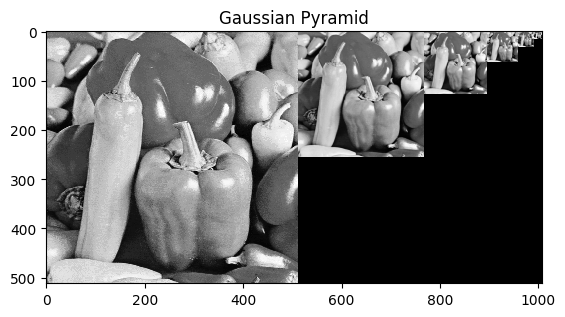

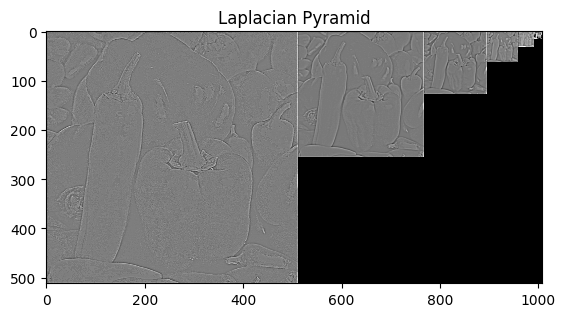

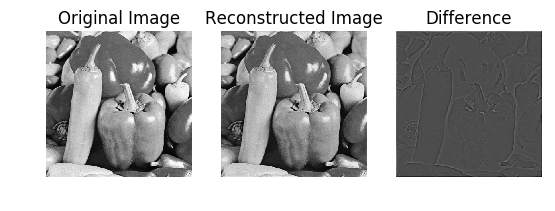

PyObject Text(0.5,1,'Difference')

In [6]:
# : Image Pyramids and Image Sharpening


  # parameters
  fsize = [5 5]
  sigma = 1.5
  nlevels = 6

   # load image
  im = PyPlot.imread("a2p1.png")
  # the image isin data-julia folder


  # create gaussian pyramid
  G = makegaussianpyramid(im,nlevels,fsize,sigma)

  # display gaussianpyramid
  displaypyramid(G)
  title("Gaussian Pyramid")

  # create laplacian pyramid
  L = makelaplacianpyramid(G,nlevels,fsize)

  # dispaly laplacian pyramid
 
  displaypyramid(L)
  title("Laplacian Pyramid")
  

  # amplify finest 2 subands
  L_amp = amplifyhighfreq2(L)
 

  # reconstruct image from laplacian pyramid
  im_rec = reconstructlaplacianpyramid(L_amp,fsize)

  # display original and reconstructed image
  figure()
  subplot(131)
  imshow(im,"gray",interpolation="none")
  axis("off")
  title("Original Image")
  subplot(132)
  imshow(im_rec,"gray",interpolation="none")
  axis("off")
  title("Reconstructed Image")
  subplot(133)
  imshow(im-im_rec,"gray",interpolation="none")
  axis("off")
  title("Difference")
 




